# Определение возраста покупателей

## Введение

<font color='navy'><b><u>Целевая задача Заказчика</b></u><i> - увеличить продажи за счет анализа покупок и возраста покупателей, чтобы формировать целевые предложения товаров по возрастным группам, кроме того, повысить эффективность контроля продажи алкогольной продукции</i><br>

<Font color='navy'><b><i><u>Цель исследования </b></i></u>- разработка модели, определяющей возраст покупателя по фотографии в прикассовой зоне

<Font color='navy'><b><i><u>Задачи исследования</b></i></u><br>&nbsp;&nbsp;&nbsp;1. провести исследовательский анализ данных- набора фотографий с отметкой о возрасте<br>&nbsp;&nbsp;&nbsp;2. осуществить обучение и оценку качества модели

<Font color='navy'><b><i><u>План исследования</b></i></u><br>&nbsp;&nbsp;&nbsp;1. загрузка библиотек и данных <br>&nbsp;&nbsp;&nbsp;2. исследовательский анализ данных<br>&nbsp;&nbsp;&nbsp;3. обучение и анализ обученной модели

## Загрузка библиотек и данных

In [1]:
# Импортируем необходимые бибилотеки
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, MaxPooling2D

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip=True)
    
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
# размер выборки
print(f"Размер выборки: {datagen_flow.samples}")

# размер батча:
batch_X, batch_y = next(datagen_flow)  # Получаем один пакет
print(f"размер батча изображений: {batch_X.shape}")  
print(f"размер батча целевого признака: {batch_y.shape}") 

Размер выборки: 7591
размер батча изображений: (32, 224, 224, 3)
размер батча целевого признака: (32,)


<Font color='navy'><b><u>Вывод</b></u><br>Данные содержат 7591 объект: датасет `labels` количество записей 7591 с наименованием файла с изображением и возрастом (целевой признак), изображенного человека и папка `final_files` с 7591 фотографией.

## Исследовательский анализ данных

<Font color='navy'>Посмотрим на распределение возраста в выборке

In [4]:
labels.describe(percentiles=[0.025, 0.5, 0.975]).T

,count,mean,std,min,2.5%,50%,97.5%,max
real_age,7591.0,31.201159,17.14506,1.0,2.0,29.0,71.0,100.0


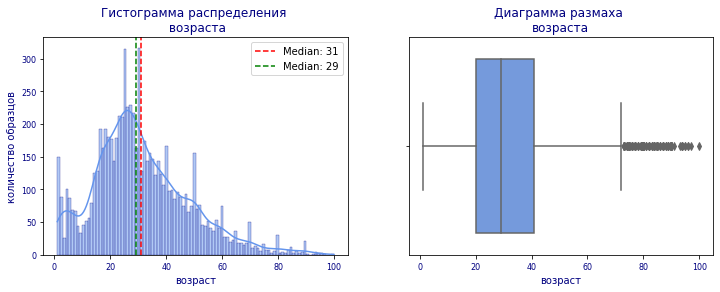

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=labels, x='real_age', bins = 100, \
             color = 'cornflowerblue', \
             edgecolor = 'navy', \
             stat='count', common_norm=False, kde=True)

age_mean_value = round(labels['real_age'].mean())
age_median_value = round(labels['real_age'].median())
plt.axvline(age_mean_value, color='red', linestyle='--', label=f'Median: {age_mean_value}')
plt.axvline(age_median_value, color='green', linestyle='--', label=f'Median: {age_median_value}')
 
plt.title(f'Гистограмма распределения \n возраста',  fontsize=12, color='navy')
plt.xlabel('возраст', fontsize=10, color='navy')
plt.ylabel('количество образцов', fontsize=10, color='navy')
plt.yticks(fontsize=8, color='navy')
plt.xticks(fontsize=8, color='navy')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=labels, x='real_age', 
                color = 'cornflowerblue')
plt.title(f'Диаграмма размаха \nвозраста',  fontsize=12, color='navy')
plt.xlabel('возраст', fontsize=10, color='navy')
plt.xticks(fontsize=8, color='navy')
plt.show()

<Font color='navy'>Выведем на экран 10 фотографий с метками возраста из предоставленных данных

In [6]:
# Функция для отображения изображений
def display_images(data, num_images):
    images = []
    labels = []
    for _ in range(num_images):
        x_batch, y_batch = next(data)
        images.append(x_batch)
        labels.append(y_batch)

    # Создаем сетку для отображения изображений
    plt.figure(figsize=(24, 8))
    for i in range(num_images):
        plt.subplot(2, int(num_images/2), i+1)
        if i <= 5:
            plt.imshow(images[i][0])
            plt.title(f'Возраст: {labels[i][0]}')
            plt.axis('off')
        else:
            plt.imshow(images[i][1])
            plt.title(f'Возраст: {labels[i][1]}')
            plt.axis('off')
    plt.show()

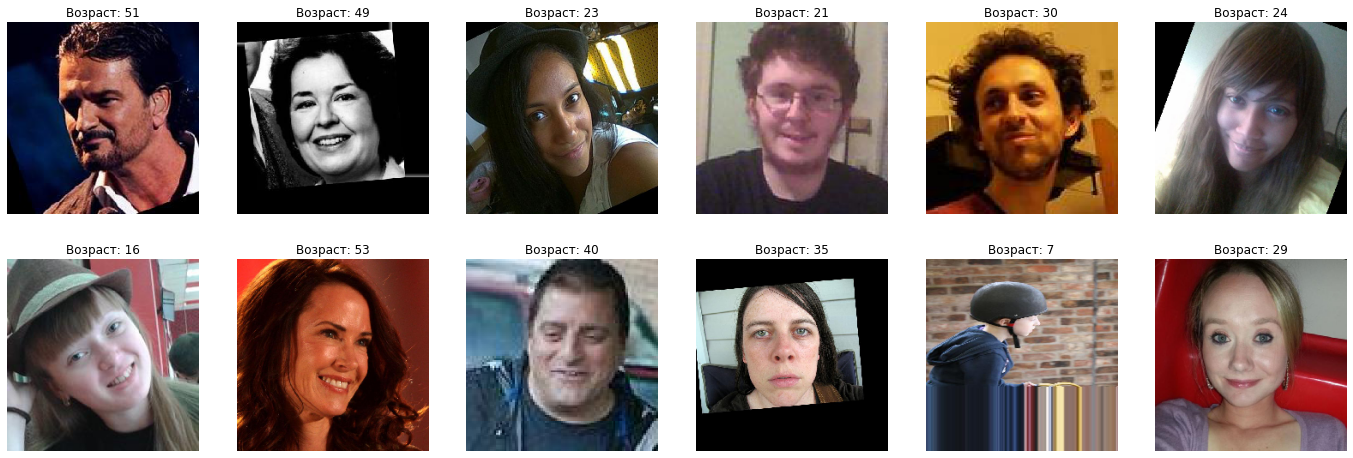

In [7]:
# Вызываем функцию для отображения 10 изображений
display_images(datagen_flow, 12)

<Font color='navy'><b><u>Выводы</b></u><br>1.Для анализа предоставлены 7591 фотография людей обоих полов (женщины и мужчины) с метками возрастов в диапазоне от 1 года до 100 лет, выполненных в различных условиях освещенности и на разном фоне. Основная часть фотографий людей в возрасте от 1 до 71 года<br>2. Распределение данных бимодальное с незначительной правосторонней асимметрией - два пика: основной пик расположен немного левее значения медианы (29 лет) в районе 25-27 лет, второй пик расположен от 1 года до 5 лет. Кроме того, на графике видны пики количества фотографий в районе "юбилейных" лет, которые могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и разметка делалась путем предположения порядка возрастной группы. Такие особенности могут негативно повлиять на качество прогноза.<br>3. Все изображения содержатся в файлах формата jpg, имеют три цветовых канала RGB, квадратную форму и разные размеры. Для предсказания потребуется предобученная сверточная нейросеть типа ResNet<br>4. Различия в мимике, позах и освещении говорит о необходимости применения аугментации данных. Общая ориентация фотографий примерно одинакова - некоторые фотографии уже повернуты, для выравнивания положения лица, что означает, что нет необходимости вповороте фотографии, а начальный размер изображений отличается, в силу того, что визуально заметно различное качество фото, где-то есть черные рамки (они не несут полезной информации). В итоге, размер изображений неоходимо привести к единому перед обучением модели.

## Обучение модели

```python

import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(validation_split=0.25, 
                                 rescale=1./255, 
                                 rotation_range = 40,
                                 width_shift_range = 30,
                                 height_shift_range = 30,
                                 zoom_range = [.8, .8],
                                 horizontal_flip = True)
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer_adam = Adam(lr=.00001)
    model.compile(optimizer=optimizer_adam, 
                  loss='mean_squared_error', 
                  metrics=['mae'])

    model.summary() 

    return model

def train_model(model, train_data,
                test_data, 
                batch_size=None, epochs=15, 
                steps_per_epoch=None, 
                validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              shuffle=True,
              verbose=2)

    return model

```

```

# Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 60 steps
Epoch 1/15
2025-02-05 07:52:37.652425: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-05 07:52:39.160541: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 135s - loss: 738.3909 - mae: 22.1712 - val_loss: 689.5031 - val_mae: 21.2928
Epoch 2/15
356/356 - 101s - loss: 189.9255 - mae: 10.3995 - val_loss: 168.5773 - val_mae: 9.9578
Epoch 3/15
356/356 - 102s - loss: 124.3562 - mae: 8.4453 - val_loss: 131.0102 - val_mae: 8.7030
Epoch 4/15
356/356 - 109s - loss: 106.1541 - mae: 7.7548 - val_loss: 97.4724 - val_mae: 7.5063
Epoch 5/15
356/356 - 108s - loss: 96.6597 - mae: 7.4429 - val_loss: 97.6252 - val_mae: 7.4398
Epoch 6/15
356/356 - 109s - loss: 85.2090 - mae: 7.0632 - val_loss: 99.1105 - val_mae: 7.5249
Epoch 7/15
356/356 - 107s - loss: 77.5241 - mae: 6.7710 - val_loss: 92.7889 - val_mae: 7.2565
Epoch 8/15
356/356 - 108s - loss: 72.2929 - mae: 6.4864 - val_loss: 104.1189 - val_mae: 7.5388
Epoch 9/15
356/356 - 104s - loss: 68.2469 - mae: 6.3653 - val_loss: 88.9775 - val_mae: 7.1373
Epoch 10/15
356/356 - 112s - loss: 62.7026 - mae: 6.0901 - val_loss: 94.0373 - val_mae: 7.2852
Epoch 11/15
356/356 - 118s - loss: 58.0441 - mae: 5.9218 - val_loss: 92.0433 - val_mae: 7.1465
Epoch 12/15
356/356 - 119s - loss: 57.7615 - mae: 5.8900 - val_loss: 90.5523 - val_mae: 7.0539
Epoch 13/15
356/356 - 117s - loss: 53.7508 - mae: 5.6575 - val_loss: 93.7541 - val_mae: 7.4019
Epoch 14/15
356/356 - 119s - loss: 52.3193 - mae: 5.6138 - val_loss: 91.3051 - val_mae: 7.2344
Epoch 15/15
356/356 - 118s - loss: 49.0035 - mae: 5.3794 - val_loss: 89.7160 - val_mae: 7.1340
WARNING:tensorflow:sample_weight modes were coerced from

```

## Анализ обученной модели

<Font color='navy'> В результате выполнения кода, созданной нейросети, на валидационных данных получено значение показателя `средней абсолютной ошибки (mae)` равного 7.134. <br>
Созданная в рамках проекта модель позволяет предсказывать возраст покупателя с точностью 7 лет, что меньше установленного Закзачиком порога - 8 лет.<br>
В ходе выполнения проекта были использованы различные методы повышения качества прогноза:<br>&nbsp;&nbsp;&nbsp;- применение различных вариантов аугментации данных;<br>&nbsp;&nbsp;&nbsp;- увеличение сложности модели: добавление дополнительных Dense-слоев или увеличение числа нейронов в них с разными функциями активации<br>&nbsp;&nbsp;&nbsp;- добавление дополнительных слоев нормализации и регуляризации Dropout, BatchNormalizator и LayerNormalizator<br>&nbsp;&nbsp;&nbsp;- подбор гиперпараметров (скорости обучения и оптимизаторов)<br>&nbsp;&nbsp;&nbsp;- использование EarlyStopping для контроля переобучения и ModelCheckpoint для сохранения лучших весов<br>&nbsp;&nbsp;&nbsp;- дообучение предобученной сети ResNet50<br>В резульате, сочетание тонкой настройки аугментации и достаточно простой архитектуры нейросети дала необходимую точность прогноза.<br> Повышение точности прогноза, необходимое для реализации целевых задач бизнеса (маркетинговые предложения в зависимости от возраста и контроль продажи алкоголя), возможно по двум направлениям:<br>&nbsp;&nbsp;&nbsp;- изменение целевого признака с возраста на возрастную группу<br>&nbsp;&nbsp;&nbsp;- выравнивание количества фотографий различных возрастных групп<br>&nbsp;&nbsp;&nbsp;- исключение из датасета данных с фотографиями людей, которые очевидно не являются целевой аудиторией - дети младше 10 лет и пожилые люди старше 80